In [1]:
#!/usr/bin/env python3
from diffwave.inference import predict as diffwave_predict
import torch
import numpy as np
import pandas as pd
import torchaudio
import soundfile as sf
import librosa
from pymcd.mcd import Calculate_MCD
from pystoi import stoi
from pesq import pesq
import time
import os
from glob import glob
import gc
import IPython.display as ipd

# Set CUDA device
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Setup paths
model_dir = 'diffwave-ljspeech-22kHz-1000578.pt'
audio_dir = 'audio'

print("Libraries imported successfully!")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Model path: {model_dir}")
print(f"Audio directory: {audio_dir}")


Libraries imported successfully!
CUDA available: True
Model path: diffwave-ljspeech-22kHz-1000578.pt
Audio directory: audio


In [2]:
def benchmark_single_inference(mel_file, original_audio_file, model_dir, trial_num=1, show_audio=False):
    """
    Benchmark a single inference run with all metrics
    """
    print(f"  Trial {trial_num}: Processing {mel_file}")
    
    # Load mel spectrogram
    mel_spec = np.load(mel_file)
    mel_tensor = torch.from_numpy(mel_spec).float().unsqueeze(0).to('cuda')
    
    # Clear GPU cache and measure initial memory
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    
    # Time the inference
    start_time = time.time()
    generated_audio, sample_rate = diffwave_predict(mel_tensor, model_dir, fast_sampling=True)
    torch.cuda.synchronize()  # Ensure all CUDA operations complete
    end_time = time.time()
    
    # Measure peak GPU memory
    peak_memory_mb = torch.cuda.max_memory_allocated() / (1024 * 1024)
    
    # Calculate timing metrics
    inference_time = end_time - start_time
    audio_duration = len(generated_audio.squeeze()) / sample_rate
    rtf = inference_time / audio_duration
    
    # Save generated audio permanently
    os.makedirs("benchmark_results", exist_ok=True)
    duration_name = os.path.basename(original_audio_file).replace('.wav', '')
    output_file = f"benchmark_results/generated_{duration_name}_trial{trial_num}.wav"
    audio_for_save = generated_audio.squeeze().cpu()
    torchaudio.save(output_file, audio_for_save.unsqueeze(0), sample_rate)
    
    # # Display audio status (disabled to prevent memory issues)
    # if show_audio:
    #     duration_name = os.path.basename(original_audio_file).replace('.wav', '')
    #     print(f"    ✅ Audio generated successfully for {duration_name}: {len(audio_for_save)/sample_rate:.1f}s duration")
    #     # ipd.display disabled to prevent memory leaks
    
    # Calculate quality metrics
    try:
        # MCD
        mcd_toolbox = Calculate_MCD(MCD_mode="dtw")
        mcd_score = mcd_toolbox.calculate_mcd(original_audio_file, output_file)
        
        # Load audio for STOI and PESQ
        original_audio, sr_orig = sf.read(original_audio_file)
        generated_audio_np, sr_gen = sf.read(output_file)
        
        # Resample if needed
        if sr_orig != sr_gen:
            generated_audio_np = librosa.resample(y=generated_audio_np, orig_sr=sr_gen, target_sr=sr_orig)
        
        # Align lengths
        min_len = min(len(original_audio), len(generated_audio_np))
        original_audio = original_audio[:min_len]
        generated_audio_np = generated_audio_np[:min_len]
        
        # STOI
        stoi_score = stoi(original_audio, generated_audio_np, sr_orig, extended=False)
        
        # WB-PESQ (need 16kHz) - Use first 60s for long audio due to library limitations
        if audio_duration >= 120.0:
            # Truncate to first 60s for PESQ calculation (quality is typically consistent)
            max_samples_60s = int(60.0 * sr_orig)
            original_for_pesq = original_audio[:max_samples_60s]
            generated_for_pesq = generated_audio_np[:max_samples_60s]
            print(f"    PESQ calculated on first 60s (original audio: {audio_duration:.1f}s)")
        else:
            original_for_pesq = original_audio
            generated_for_pesq = generated_audio_np
        
        sr_pesq = 16000
        original_16k = librosa.resample(y=original_for_pesq, orig_sr=sr_orig, target_sr=sr_pesq)
        generated_16k = librosa.resample(y=generated_for_pesq, orig_sr=sr_orig, target_sr=sr_pesq)
        pesq_score = pesq(sr_pesq, original_16k, generated_16k, 'wb')
        
    except Exception as e:
        print(f"    Error calculating quality metrics: {e}")
        mcd_score = np.nan
        stoi_score = np.nan
        pesq_score = np.nan
    
    # Clean up GPU memory (keep audio files)
    del mel_tensor, generated_audio
    torch.cuda.empty_cache()
    
    results = {
        'inference_time_s': inference_time,
        'audio_duration_s': audio_duration,
        'rtf': rtf,
        'peak_memory_mb': peak_memory_mb,
        'mcd': mcd_score,
        'stoi': stoi_score,
        'wb_pesq': pesq_score
    }
    
    print(f"    Inference: {inference_time:.3f}s, RTF: {rtf:.3f}, Memory: {peak_memory_mb:.1f}MB")
    return results


In [3]:
# Find and organize audio files by duration
def get_duration_from_filename(filename):
    """Extract duration from filename like '30s.wav' -> 30"""
    return int(filename.replace('.wav', '').replace('s', ''))

# Get all audio and mel spectrogram files
audio_files = sorted(glob(f"{audio_dir}/*.wav"), key=lambda x: get_duration_from_filename(os.path.basename(x)))
mel_files = sorted(glob(f"{audio_dir}/*_mel.npy"), key=lambda x: get_duration_from_filename(os.path.basename(x).replace('_mel.npy', 's.wav')))

print("Audio files found:")
for audio_file in audio_files:
    print(f"  {audio_file}")

print("\nMel spectrogram files found:")
for mel_file in mel_files:
    print(f"  {mel_file}")

# Create pairs
audio_mel_pairs = []
for audio_file in audio_files:
    base_name = os.path.basename(audio_file).replace('.wav', '')
    mel_file = f"{audio_dir}/{base_name}_mel.npy"
    if os.path.exists(mel_file):
        audio_mel_pairs.append((audio_file, mel_file, base_name))

print(f"\nFound {len(audio_mel_pairs)} audio-mel pairs for benchmarking")
for audio_file, mel_file, duration in audio_mel_pairs:
    print(f"  {duration}: {os.path.basename(audio_file)} + {os.path.basename(mel_file)}")


Audio files found:
  audio/1s.wav
  audio/5s.wav
  audio/15s.wav
  audio/30s.wav
  audio/60s.wav
  audio/120s.wav
  audio/240s.wav

Mel spectrogram files found:
  audio/1s_mel.npy
  audio/5s_mel.npy
  audio/15s_mel.npy
  audio/30s_mel.npy
  audio/60s_mel.npy
  audio/120s_mel.npy
  audio/240s_mel.npy

Found 7 audio-mel pairs for benchmarking
  1s: 1s.wav + 1s_mel.npy
  5s: 5s.wav + 5s_mel.npy
  15s: 15s.wav + 15s_mel.npy
  30s: 30s.wav + 30s_mel.npy
  60s: 60s.wav + 60s_mel.npy
  120s: 120s.wav + 120s_mel.npy
  240s: 240s.wav + 240s_mel.npy


In [4]:
# Initialize results storage
all_results = []

print("=== DiffWave Regular Inference Benchmarking Setup ===")
print(f"Ready to benchmark {len(audio_mel_pairs)} clip lengths with 3 trials each")
print("Run each duration cell below separately to avoid memory issues")


=== DiffWave Regular Inference Benchmarking Setup ===
Ready to benchmark 7 clip lengths with 3 trials each
Run each duration cell below separately to avoid memory issues


In [5]:
# Benchmark 1s clips
audio_file, mel_file, duration_name = audio_mel_pairs[0]  # 1s clip
print(f"=== Benchmarking {duration_name} ===")

for trial in range(1, 4):
    try:
        show_audio = (trial == 1)
        results = benchmark_single_inference(mel_file, audio_file, model_dir, trial_num=trial, show_audio=show_audio)
        
        # Add metadata
        results['duration_name'] = duration_name
        results['trial'] = trial
        results['audio_file'] = os.path.basename(audio_file)
        results['mel_file'] = os.path.basename(mel_file)
        
        all_results.append(results)
        
    except Exception as e:
        print(f"    ERROR in trial {trial}: {e}")

# Aggressive memory cleanup
torch.cuda.empty_cache()
gc.collect()
print(f"1s benchmarking complete. GPU memory: {torch.cuda.memory_allocated()/1e9:.1f}GB")


=== Benchmarking 1s ===
  Trial 1: Processing audio/1s_mel.npy
    ✅ Audio generated successfully for 1s: 1.1s duration
    Inference: 0.516s, RTF: 0.488, Memory: 116.7MB
  Trial 2: Processing audio/1s_mel.npy
    Inference: 0.083s, RTF: 0.079, Memory: 96.7MB
  Trial 3: Processing audio/1s_mel.npy
    Inference: 0.082s, RTF: 0.078, Memory: 96.7MB
1s benchmarking complete. GPU memory: 0.0GB


In [6]:
# Benchmark 5s clips
audio_file, mel_file, duration_name = audio_mel_pairs[1]  # 5s clip
print(f"=== Benchmarking {duration_name} ===")

for trial in range(1, 4):
    try:
        show_audio = (trial == 1)
        results = benchmark_single_inference(mel_file, audio_file, model_dir, trial_num=trial, show_audio=show_audio)
        
        # Add metadata
        results['duration_name'] = duration_name
        results['trial'] = trial
        results['audio_file'] = os.path.basename(audio_file)
        results['mel_file'] = os.path.basename(mel_file)
        
        all_results.append(results)
        
    except Exception as e:
        print(f"    ERROR in trial {trial}: {e}")

# Aggressive memory cleanup
torch.cuda.empty_cache()
gc.collect()
print(f"5s benchmarking complete. GPU memory: {torch.cuda.memory_allocated()/1e9:.1f}GB")


=== Benchmarking 5s ===
  Trial 1: Processing audio/5s_mel.npy
    ✅ Audio generated successfully for 5s: 5.2s duration
    Inference: 0.344s, RTF: 0.066, Memory: 393.2MB
  Trial 2: Processing audio/5s_mel.npy
    Inference: 0.342s, RTF: 0.065, Memory: 393.2MB
  Trial 3: Processing audio/5s_mel.npy
    Inference: 0.342s, RTF: 0.065, Memory: 393.2MB
5s benchmarking complete. GPU memory: 0.0GB


In [7]:
# Benchmark 15s clips  
audio_file, mel_file, duration_name = audio_mel_pairs[2]  # 15s clip
print(f"=== Benchmarking {duration_name} ===")

for trial in range(1, 4):
    try:
        show_audio = (trial == 1)
        results = benchmark_single_inference(mel_file, audio_file, model_dir, trial_num=trial, show_audio=show_audio)
        
        # Add metadata
        results['duration_name'] = duration_name
        results['trial'] = trial
        results['audio_file'] = os.path.basename(audio_file)
        results['mel_file'] = os.path.basename(mel_file)
        
        all_results.append(results)
        
    except Exception as e:
        print(f"    ERROR in trial {trial}: {e}")

# Aggressive memory cleanup
torch.cuda.empty_cache()
gc.collect()
print(f"15s benchmarking complete. GPU memory: {torch.cuda.memory_allocated()/1e9:.1f}GB")


=== Benchmarking 15s ===
  Trial 1: Processing audio/15s_mel.npy
    ✅ Audio generated successfully for 15s: 15.6s duration
    Inference: 1.012s, RTF: 0.065, Memory: 1135.7MB
  Trial 2: Processing audio/15s_mel.npy
    Inference: 1.011s, RTF: 0.065, Memory: 1135.7MB
  Trial 3: Processing audio/15s_mel.npy
    Inference: 1.012s, RTF: 0.065, Memory: 1135.7MB
15s benchmarking complete. GPU memory: 0.0GB


In [8]:
# Benchmark 30s clips  
audio_file, mel_file, duration_name = audio_mel_pairs[3]  # 30s clip
print(f"=== Benchmarking {duration_name} ===")

for trial in range(1, 4):
    try:
        show_audio = (trial == 1)
        results = benchmark_single_inference(mel_file, audio_file, model_dir, trial_num=trial, show_audio=show_audio)
        
        # Add metadata
        results['duration_name'] = duration_name
        results['trial'] = trial
        results['audio_file'] = os.path.basename(audio_file)
        results['mel_file'] = os.path.basename(mel_file)
        
        all_results.append(results)
        
    except Exception as e:
        print(f"    ERROR in trial {trial}: {e}")

# Aggressive memory cleanup
torch.cuda.empty_cache()
gc.collect()
print(f"30s benchmarking complete. GPU memory: {torch.cuda.memory_allocated()/1e9:.1f}GB")


=== Benchmarking 30s ===
  Trial 1: Processing audio/30s_mel.npy
    ✅ Audio generated successfully for 30s: 30.4s duration
    Inference: 1.901s, RTF: 0.063, Memory: 2191.2MB
  Trial 2: Processing audio/30s_mel.npy
    Inference: 1.905s, RTF: 0.063, Memory: 2191.2MB
  Trial 3: Processing audio/30s_mel.npy
    Inference: 1.910s, RTF: 0.063, Memory: 2191.2MB
30s benchmarking complete. GPU memory: 0.0GB


In [9]:
# Benchmark 60s clips  
audio_file, mel_file, duration_name = audio_mel_pairs[4]  # 60s clip
print(f"=== Benchmarking {duration_name} ===")

for trial in range(1, 4):
    try:
        show_audio = (trial == 1)
        results = benchmark_single_inference(mel_file, audio_file, model_dir, trial_num=trial, show_audio=show_audio)
        
        # Add metadata
        results['duration_name'] = duration_name
        results['trial'] = trial
        results['audio_file'] = os.path.basename(audio_file)
        results['mel_file'] = os.path.basename(mel_file)
        
        all_results.append(results)
        
    except Exception as e:
        print(f"    ERROR in trial {trial}: {e}")

# Aggressive memory cleanup
torch.cuda.empty_cache()
gc.collect()
print(f"60s benchmarking complete. GPU memory: {torch.cuda.memory_allocated()/1e9:.1f}GB")


=== Benchmarking 60s ===
  Trial 1: Processing audio/60s_mel.npy
    ✅ Audio generated successfully for 60s: 60.5s duration
    Inference: 3.766s, RTF: 0.062, Memory: 4349.8MB
  Trial 2: Processing audio/60s_mel.npy
    Inference: 3.774s, RTF: 0.062, Memory: 4349.8MB
  Trial 3: Processing audio/60s_mel.npy
    Inference: 3.773s, RTF: 0.062, Memory: 4349.8MB
60s benchmarking complete. GPU memory: 0.0GB


In [10]:
# Benchmark 120s clips  
audio_file, mel_file, duration_name = audio_mel_pairs[5]  # 120s clip
print(f"=== Benchmarking {duration_name} ===")

for trial in range(1, 4):
    try:
        show_audio = (trial == 1)
        results = benchmark_single_inference(mel_file, audio_file, model_dir, trial_num=trial, show_audio=show_audio)
        
        # Add metadata
        results['duration_name'] = duration_name
        results['trial'] = trial
        results['audio_file'] = os.path.basename(audio_file)
        results['mel_file'] = os.path.basename(mel_file)
        
        all_results.append(results)
        
    except Exception as e:
        print(f"    ERROR in trial {trial}: {e}")

# Aggressive memory cleanup
torch.cuda.empty_cache()
gc.collect()
print(f"120s benchmarking complete. GPU memory: {torch.cuda.memory_allocated()/1e9:.1f}GB")


=== Benchmarking 120s ===
  Trial 1: Processing audio/120s_mel.npy
    ✅ Audio generated successfully for 120s: 120.4s duration
    PESQ calculated on first 60s (original audio: 120.4s)
    Inference: 7.448s, RTF: 0.062, Memory: 8627.9MB
  Trial 2: Processing audio/120s_mel.npy
    PESQ calculated on first 60s (original audio: 120.4s)
    Inference: 7.451s, RTF: 0.062, Memory: 8627.9MB
  Trial 3: Processing audio/120s_mel.npy
    PESQ calculated on first 60s (original audio: 120.4s)
    Inference: 7.451s, RTF: 0.062, Memory: 8627.9MB
120s benchmarking complete. GPU memory: 0.0GB


In [11]:
# Benchmark 240s clips (WARNING: High memory usage!)
audio_file, mel_file, duration_name = audio_mel_pairs[6]  # 240s clip
print(f"=== Benchmarking {duration_name} (High Memory Usage!) ===")
print(f"GPU memory before: {torch.cuda.memory_allocated()/1e9:.1f}GB")

for trial in range(1, 4):
    try:
        show_audio = (trial == 1)
        print(f"Trial {trial} - GPU memory before: {torch.cuda.memory_allocated()/1e9:.1f}GB")
        
        results = benchmark_single_inference(mel_file, audio_file, model_dir, trial_num=trial, show_audio=show_audio)
        
        # Add metadata
        results['duration_name'] = duration_name
        results['trial'] = trial
        results['audio_file'] = os.path.basename(audio_file)
        results['mel_file'] = os.path.basename(mel_file)
        
        all_results.append(results)
        
        # Extra cleanup after each trial for 240s
        torch.cuda.empty_cache()
        gc.collect()
        print(f"Trial {trial} complete - GPU memory after cleanup: {torch.cuda.memory_allocated()/1e9:.1f}GB")
        
    except Exception as e:
        print(f"    ERROR in trial {trial}: {e}")
        # Force cleanup on error
        torch.cuda.empty_cache()
        gc.collect()

print(f"240s benchmarking complete. Final GPU memory: {torch.cuda.memory_allocated()/1e9:.1f}GB")


=== Benchmarking 240s (High Memory Usage!) ===
GPU memory before: 0.0GB
Trial 1 - GPU memory before: 0.0GB
  Trial 1: Processing audio/240s_mel.npy
    ✅ Audio generated successfully for 240s: 240.4s duration
    PESQ calculated on first 60s (original audio: 240.4s)
    Inference: 14.831s, RTF: 0.062, Memory: 17210.8MB
Trial 1 complete - GPU memory after cleanup: 0.0GB
Trial 2 - GPU memory before: 0.0GB
  Trial 2: Processing audio/240s_mel.npy
    PESQ calculated on first 60s (original audio: 240.4s)
    Inference: 15.132s, RTF: 0.063, Memory: 17210.8MB
Trial 2 complete - GPU memory after cleanup: 0.0GB
Trial 3 - GPU memory before: 0.0GB
  Trial 3: Processing audio/240s_mel.npy
    PESQ calculated on first 60s (original audio: 240.4s)
    Inference: 15.089s, RTF: 0.063, Memory: 17210.8MB
Trial 3 complete - GPU memory after cleanup: 0.0GB
240s benchmarking complete. Final GPU memory: 0.0GB


In [12]:
# Convert to DataFrame
df = pd.DataFrame(all_results)

# Save raw results to CSV
csv_filename = 'diffwave_regular_benchmark_results.csv'
df.to_csv(csv_filename, index=False)
print(f"Raw results saved to: {csv_filename}")

# Display first few rows
print("\nFirst 5 rows of results:")
print(df.head())

print(f"\nDataFrame shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Check for any failed experiments
failed_count = df.isna().any(axis=1).sum()
if failed_count > 0:
    print(f"\nWarning: {failed_count} experiments failed (contain NaN values)")
else:
    print("\nAll experiments completed successfully!")


Raw results saved to: diffwave_regular_benchmark_results.csv

First 5 rows of results:
   inference_time_s  audio_duration_s       rtf  peak_memory_mb       mcd  \
0          0.515734          1.056508  0.488150      116.735840  1.264177   
1          0.083252          1.056508  0.078799       96.727051  1.176434   
2          0.081923          1.056508  0.077541       96.727051  1.197540   
3          0.344094          5.224490  0.065862      393.173828  2.308938   
4          0.341576          5.224490  0.065380      393.173828  2.451689   

       stoi   wb_pesq duration_name  trial audio_file    mel_file  
0  0.880223  2.161374            1s      1     1s.wav  1s_mel.npy  
1  0.881391  2.157879            1s      2     1s.wav  1s_mel.npy  
2  0.863308  2.025965            1s      3     1s.wav  1s_mel.npy  
3  0.916233  2.480507            5s      1     5s.wav  5s_mel.npy  
4  0.908957  2.437878            5s      2     5s.wav  5s_mel.npy  

DataFrame shape: (21, 11)
Columns: ['infe

In [13]:
# Statistical analysis: Group by duration and compute mean ± std
print("=== Statistical Analysis: Mean ± Standard Deviation by Clip Length ===")

# Numeric columns for analysis
metric_columns = ['inference_time_s', 'audio_duration_s', 'rtf', 'peak_memory_mb', 'mcd', 'stoi', 'wb_pesq']

# Group by duration and calculate statistics
stats_summary = df.groupby('duration_name')[metric_columns].agg(['mean', 'std']).round(4)

# Create a cleaner summary table
summary_results = []

for duration in sorted(df['duration_name'].unique(), key=lambda x: int(x.replace('s', ''))):
    row = {'Duration': duration}
    
    for metric in metric_columns:
        mean_val = stats_summary.loc[duration, (metric, 'mean')]
        std_val = stats_summary.loc[duration, (metric, 'std')]
        
        # Format as "mean ± std"
        if pd.isna(mean_val) or pd.isna(std_val):
            formatted = "N/A"
        else:
            formatted = f"{mean_val:.3f} ± {std_val:.3f}"
        
        row[metric] = formatted
    
    summary_results.append(row)

# Convert to DataFrame and display
summary_df = pd.DataFrame(summary_results)
print("\nSummary Statistics (Mean ± Std):")
print(summary_df.to_string(index=False))

# Save summary to CSV
summary_csv = 'diffwave_regular_benchmark_summary.csv'
summary_df.to_csv(summary_csv, index=False)
print(f"\nSummary saved to: {summary_csv}")


=== Statistical Analysis: Mean ± Standard Deviation by Clip Length ===

Summary Statistics (Mean ± Std):
Duration inference_time_s audio_duration_s           rtf    peak_memory_mb           mcd          stoi       wb_pesq
      1s    0.227 ± 0.250    1.056 ± 0.000 0.215 ± 0.237  103.397 ± 11.552 1.213 ± 0.046 0.875 ± 0.010 2.115 ± 0.077
      5s    0.343 ± 0.001    5.224 ± 0.000 0.066 ± 0.000   393.174 ± 0.000 2.258 ± 0.224 0.921 ± 0.014 2.502 ± 0.078
     15s    1.011 ± 0.000   15.604 ± 0.000 0.065 ± 0.000  1135.692 ± 0.000 2.430 ± 0.027 0.929 ± 0.003 2.467 ± 0.035
     30s    1.905 ± 0.005   30.360 ± 0.000 0.063 ± 0.000  2191.235 ± 0.000 2.011 ± 0.034 0.932 ± 0.005 2.455 ± 0.014
     60s    3.771 ± 0.004   60.546 ± 0.000 0.062 ± 0.000  4349.794 ± 0.000 2.459 ± 0.025 0.924 ± 0.001 2.451 ± 0.022
    120s    7.450 ± 0.002  120.361 ± 0.000 0.062 ± 0.000  8627.929 ± 0.000 2.584 ± 0.018 0.912 ± 0.001 2.370 ± 0.039
    240s   15.018 ± 0.163  240.361 ± 0.000 0.062 ± 0.001 17210.770 ± 0.000 3

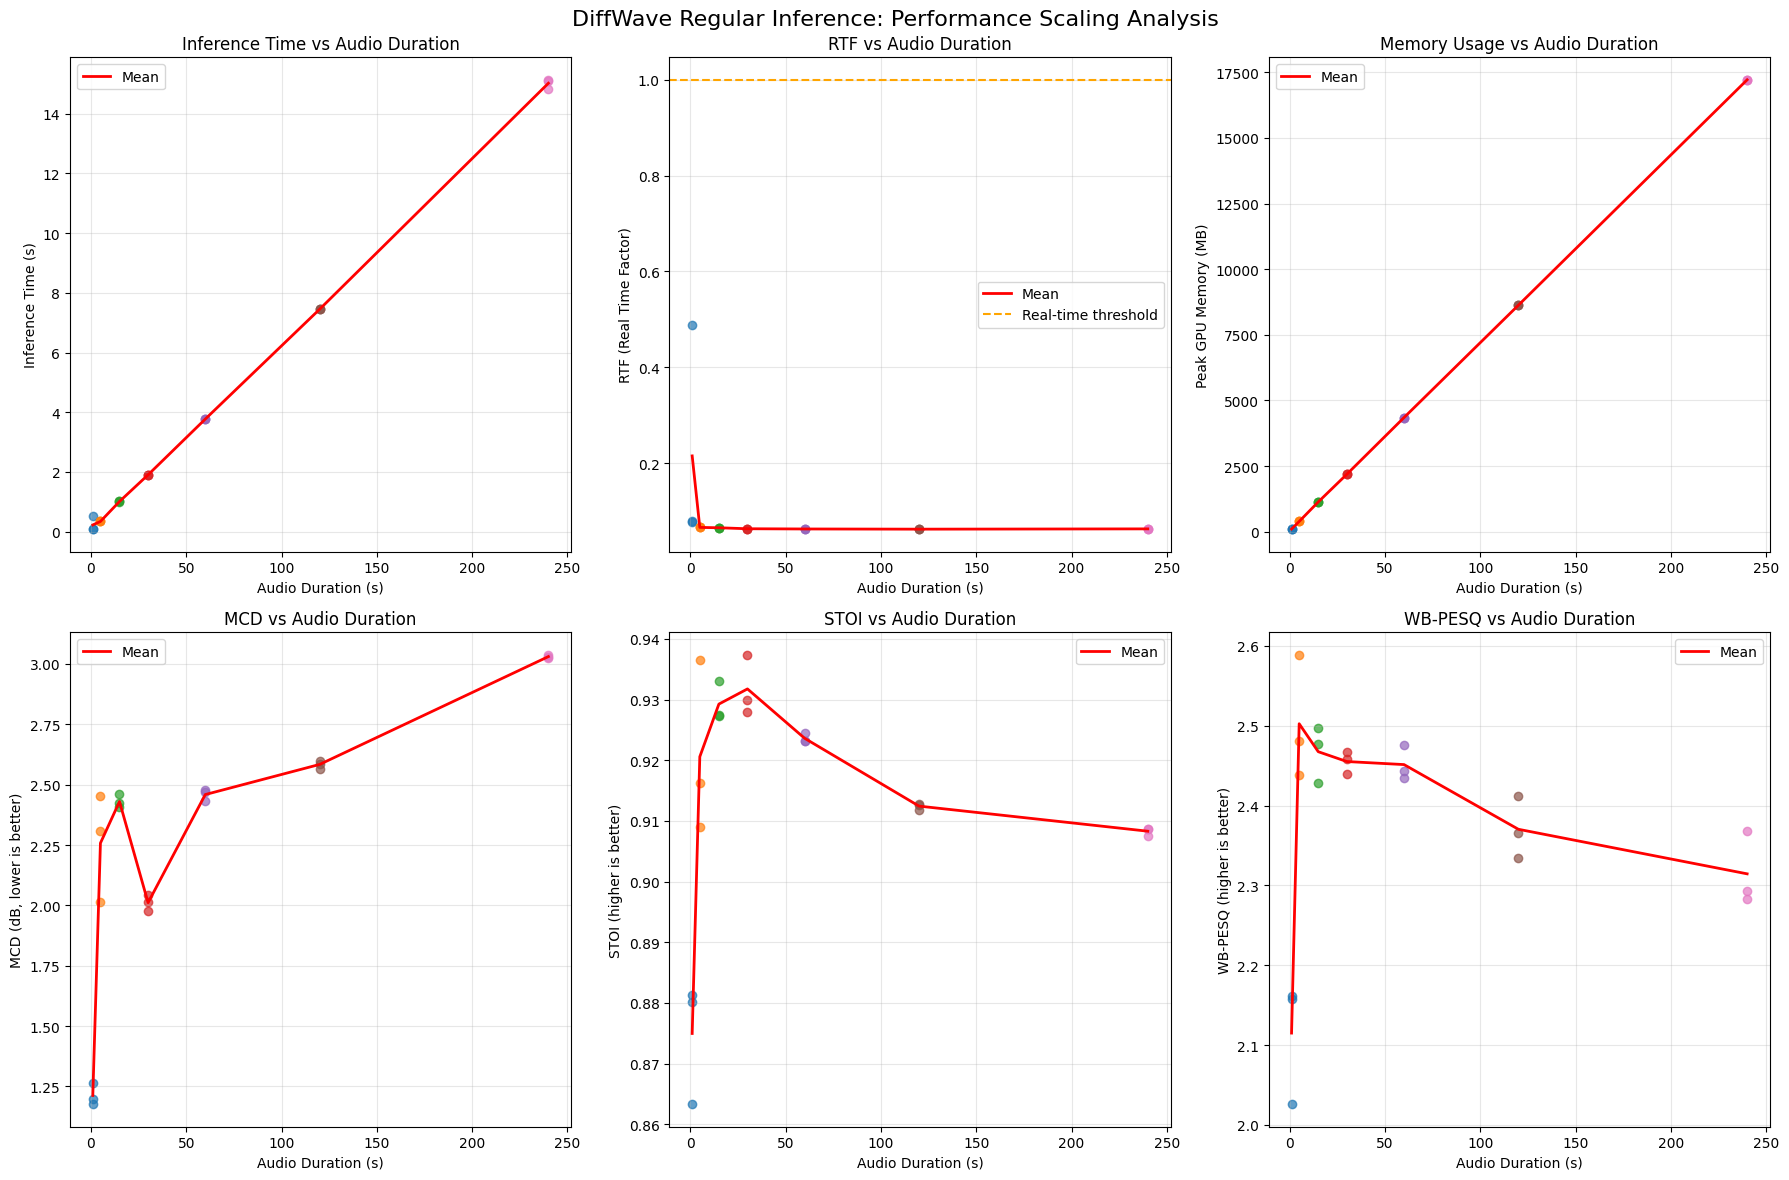

Performance analysis plots saved as: diffwave_regular_benchmark_analysis.png


In [14]:
import matplotlib.pyplot as plt

# Create visualization of scaling relationships
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('DiffWave Regular Inference: Performance Scaling Analysis', fontsize=16)

# Convert duration names to numeric for plotting
duration_numeric = [int(d.replace('s', '')) for d in df['duration_name']]
df['duration_numeric'] = duration_numeric

# Plot 1: Inference Time vs Audio Length
ax = axes[0, 0]
for duration in sorted(df['duration_name'].unique(), key=lambda x: int(x.replace('s', ''))):
    subset = df[df['duration_name'] == duration]
    ax.scatter([int(duration.replace('s', ''))] * len(subset), subset['inference_time_s'], alpha=0.7)

# Plot mean line
means = df.groupby('duration_numeric')['inference_time_s'].mean()
ax.plot(means.index, means.values, 'r-', linewidth=2, label='Mean')
ax.set_xlabel('Audio Duration (s)')
ax.set_ylabel('Inference Time (s)')
ax.set_title('Inference Time vs Audio Duration')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: RTF vs Audio Length
ax = axes[0, 1]
for duration in sorted(df['duration_name'].unique(), key=lambda x: int(x.replace('s', ''))):
    subset = df[df['duration_name'] == duration]
    ax.scatter([int(duration.replace('s', ''))] * len(subset), subset['rtf'], alpha=0.7)

means = df.groupby('duration_numeric')['rtf'].mean()
ax.plot(means.index, means.values, 'r-', linewidth=2, label='Mean')
ax.axhline(y=1.0, color='orange', linestyle='--', label='Real-time threshold')
ax.set_xlabel('Audio Duration (s)')
ax.set_ylabel('RTF (Real Time Factor)')
ax.set_title('RTF vs Audio Duration')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Peak Memory vs Audio Length
ax = axes[0, 2]
for duration in sorted(df['duration_name'].unique(), key=lambda x: int(x.replace('s', ''))):
    subset = df[df['duration_name'] == duration]
    ax.scatter([int(duration.replace('s', ''))] * len(subset), subset['peak_memory_mb'], alpha=0.7)

means = df.groupby('duration_numeric')['peak_memory_mb'].mean()
ax.plot(means.index, means.values, 'r-', linewidth=2, label='Mean')
ax.set_xlabel('Audio Duration (s)')
ax.set_ylabel('Peak GPU Memory (MB)')
ax.set_title('Memory Usage vs Audio Duration')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: MCD vs Audio Length
ax = axes[1, 0]
valid_mcd = df.dropna(subset=['mcd'])
for duration in sorted(valid_mcd['duration_name'].unique(), key=lambda x: int(x.replace('s', ''))):
    subset = valid_mcd[valid_mcd['duration_name'] == duration]
    ax.scatter([int(duration.replace('s', ''))] * len(subset), subset['mcd'], alpha=0.7)

if not valid_mcd.empty:
    means = valid_mcd.groupby('duration_numeric')['mcd'].mean()
    ax.plot(means.index, means.values, 'r-', linewidth=2, label='Mean')
ax.set_xlabel('Audio Duration (s)')
ax.set_ylabel('MCD (dB, lower is better)')
ax.set_title('MCD vs Audio Duration')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 5: STOI vs Audio Length
ax = axes[1, 1]
valid_stoi = df.dropna(subset=['stoi'])
for duration in sorted(valid_stoi['duration_name'].unique(), key=lambda x: int(x.replace('s', ''))):
    subset = valid_stoi[valid_stoi['duration_name'] == duration]
    ax.scatter([int(duration.replace('s', ''))] * len(subset), subset['stoi'], alpha=0.7)

if not valid_stoi.empty:
    means = valid_stoi.groupby('duration_numeric')['stoi'].mean()
    ax.plot(means.index, means.values, 'r-', linewidth=2, label='Mean')
ax.set_xlabel('Audio Duration (s)')
ax.set_ylabel('STOI (higher is better)')
ax.set_title('STOI vs Audio Duration')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 6: WB-PESQ vs Audio Length
ax = axes[1, 2]
valid_pesq = df.dropna(subset=['wb_pesq'])
for duration in sorted(valid_pesq['duration_name'].unique(), key=lambda x: int(x.replace('s', ''))):
    subset = valid_pesq[valid_pesq['duration_name'] == duration]
    ax.scatter([int(duration.replace('s', ''))] * len(subset), subset['wb_pesq'], alpha=0.7)

if not valid_pesq.empty:
    means = valid_pesq.groupby('duration_numeric')['wb_pesq'].mean()
    ax.plot(means.index, means.values, 'r-', linewidth=2, label='Mean')
ax.set_xlabel('Audio Duration (s)')
ax.set_ylabel('WB-PESQ (higher is better)')
ax.set_title('WB-PESQ vs Audio Duration')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('diffwave_regular_benchmark_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Performance analysis plots saved as: diffwave_regular_benchmark_analysis.png")
